# 📌 Anomaly Detection on Credit Card Transactions
# 📂 Dataset Description
The dataset contains transactions made by credit cards in September 2013 by European cardholders.

- The data spans two days, totaling 284,807 transactions, of which 492 are frauds.

- This represents a highly imbalanced dataset, where frauds make up only 0.172% of all transactions.

- All feature variables are numerical and result from a PCA transformation, except:

  -  Time: Seconds elapsed between each transaction and the first.

  - Amount: The transaction amount.

- Class is the target variable: 1 for fraud, 0 for normal.

Due to confidentiality, the original feature meanings aren't disclosed. Features V1 to V28 are PCA components.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [3]:
df.head()
# and due to confidentiality issues, the original features and the background information could not be provided

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### We would look into the features and see if they have the normal distribution shape that can align with the assumption of gaussian modelElse, we would have to convert them


In [4]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

## Feature Exploration

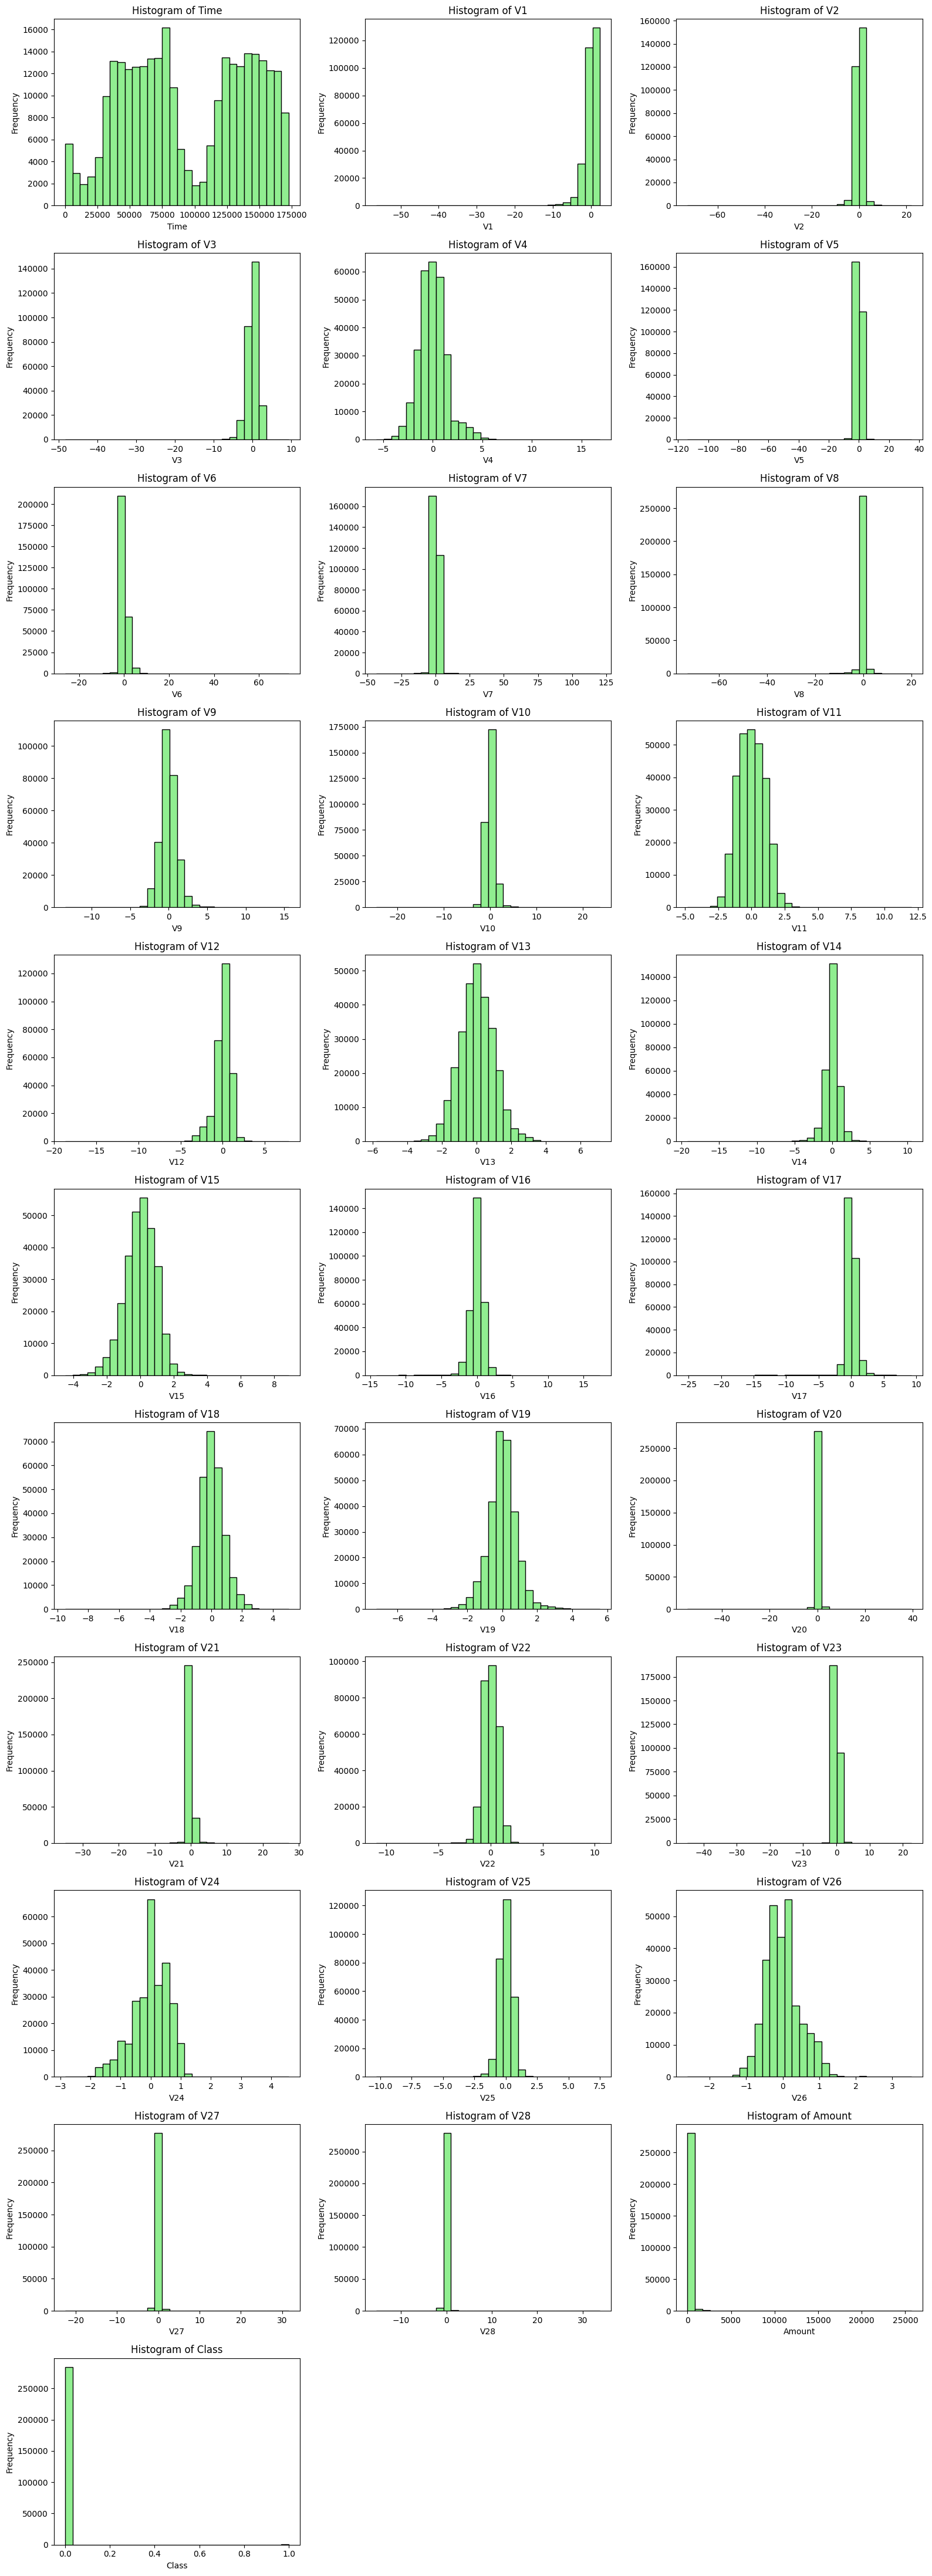

In [5]:
# Select only numeric features
features = df.columns

# Grid settings
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division for rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

# Plot each histogram
for i, column in enumerate(features):
    axes[i].hist(df[column], bins=30, color='lightgreen', edgecolor='black')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove unused axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

> So as we can see now we have gaussian like features, asides the Time features.

> Point to note though, we have the rest of the features in a normal distribution because from the source of the dataset they have all been pca transformed. So now we transform our Time.

> And it is important we do it at this stage, so that it would reflect on the data before splitting obviously

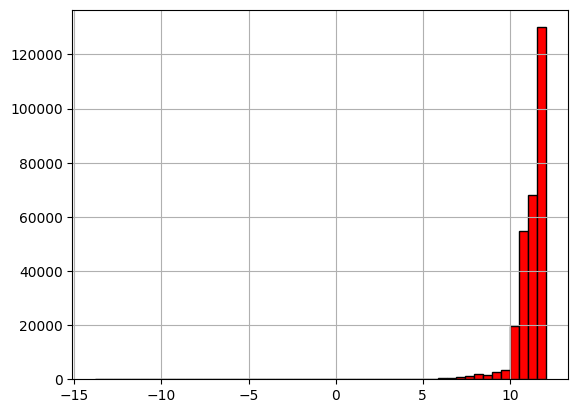

In [6]:
plt.hist(np.log(df['Time']+0.000001),bins=50,color = 'r',edgecolor='black')
plt.grid(True)
plt.show()

#### After testing, the above plot is what works best for us relatively

In [7]:
df['Time'] = df['Time']**0.33

> Lets split this into test, training, validation set. 

> Remember, per the discretion I set, the training set would have 60% of the non-anomalous dataset

> The validation set would have 20% of the non-anomalous dataset, and 50% of the anomalous dataset

>The test set would have 20% of the non-anomalous dataset, and 50% of the anomalous dataset

In [8]:
# we are splitting based on the class. i.e. where class 1 is fraud (anomalous) and class 0 is no fraud (non-anomalous)

In [9]:
df_anomaly = df[df['Class']==1]

In [10]:
df_non_anomaly = df[df['Class']==0]

In [11]:
train_set, cv_test_set_n_a = train_test_split(df_non_anomaly, test_size=0.4, random_state=42)

In [12]:
test_set_n, cv_set_n = train_test_split(cv_test_set_n_a, test_size=0.5, random_state=42)

In [13]:
test_set_a, cv_set_a = train_test_split(df_anomaly, test_size=0.5, random_state=42)

In [14]:
cv_set=pd.concat([cv_set_a,cv_set_n],axis = 0,ignore_index=True)

In [15]:
cv_set

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,29.584285,-29.200329,16.155701,-30.013712,6.476731,-21.225810,-4.902997,-19.791248,19.168327,-3.617242,...,1.809371,-2.175815,-1.365104,0.174286,2.103868,-0.209944,1.278681,0.372393,99.99,1
1,26.963764,-18.018561,10.558600,-24.667741,11.786180,-10.564657,-2.645681,-18.023468,2.693655,-6.219464,...,-2.319479,0.908839,1.352904,-1.059222,0.185751,0.687037,2.078081,-1.429517,1.00,1
2,42.382637,-7.030308,3.421991,-9.525072,5.270891,-4.024630,-2.865682,-6.989195,3.791551,-4.622730,...,1.103398,-0.541855,0.036943,-0.355519,0.353634,1.042458,1.359516,-0.272188,0.00,1
3,43.311351,-1.855061,1.554964,-1.405809,0.669327,-0.280230,1.178652,-3.459979,-2.815155,1.242229,...,-0.095308,0.946629,-0.297403,-0.368344,0.198731,-0.078591,0.366709,0.073767,38.76,1
4,28.848956,-19.856322,12.095893,-22.464083,6.115541,-15.148022,-4.346724,-15.648507,13.276805,-3.974162,...,1.750730,-1.409636,-0.809809,0.121397,1.350300,-0.224292,1.597621,0.476920,99.99,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57104,33.020774,1.284184,-0.624467,0.546700,-0.746746,-1.119287,-0.716275,-0.605650,-0.050394,-1.014342,...,-0.020744,-0.319288,0.088105,0.300206,0.178919,-0.502173,-0.002485,0.019230,49.97,0
57105,47.902989,-0.390465,1.123445,-2.339015,-0.525516,1.196793,-1.170958,1.964362,-0.480203,-0.325807,...,0.417477,1.670874,0.182313,0.704409,-1.119212,0.317148,-0.065742,0.037987,86.77,0
57106,40.104780,1.217908,0.436888,0.545318,2.539574,0.125866,0.354871,-0.023759,0.000002,-0.256410,...,-0.126509,-0.128319,-0.191686,-0.408114,0.764032,0.126782,0.012676,0.013474,3.80,0
57107,35.739103,-0.288353,1.115262,0.307150,0.828829,0.045692,-0.290727,0.519523,0.277816,-0.716060,...,0.149107,0.294714,-0.059942,-0.439985,0.009187,-0.278567,-0.057753,-0.022668,53.70,0


In [16]:
cv_set = cv_set.sample(frac=1, random_state=42).reset_index(drop=True)

#reshuffling 100% of the data to make it more generalized

In [17]:
test_set=pd.concat([test_set_a,test_set_n],axis = 0,ignore_index=True)

In [18]:
test_set=test_set.sample(frac=1, random_state=42).reset_index(drop=True)

## No need to standardize because PC has already been performed on the dataset

> Now let's estimate Gaussian Parameters which is mu(mean) and sigma(variance), from training data which then would be used to compute probabilities and getting (tuning) threshold

In [19]:
mu = train_set.mean(axis=0)

# getting the mean across all the features

In [20]:
sigma = np.cov(train_set,rowvar=False)

# getting the variance across all the features.
# this is just training, that is extracting the (weights and bias)

In [21]:
# Compute probabilities for validation set

Gaussian_model = multivariate_normal(mean=mu,cov=sigma, allow_singular=True)

In [22]:
cv_set.shape

(57109, 31)

In [23]:
probs = Gaussian_model.pdf(cv_set)

In [24]:
probs[62]

3.040421002772019e-20

> Now lets set a threshold. We would observe the probabilities before we set the threshold

In [25]:
obs_set=cv_set.copy()
# testing a random set to see where to select epsilon from

In [26]:
len(obs_set), len(probs)

(57109, 57109)

In [27]:
obs_set['probs']=probs

In [28]:
obs_set.sort_values(by='probs')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,probs
24565,48.607255,0.290155,0.049243,-0.740524,2.865463,1.395294,-0.535163,0.142543,-0.222770,-1.463691,...,1.018191,0.303550,0.833886,-1.222306,2.745261,-0.220402,0.168233,7.18,1,0.000000e+00
49012,50.840929,-1.053840,4.362801,-6.023534,5.304534,1.480738,-2.193821,-1.530817,0.626857,-4.037021,...,-0.945402,-0.376138,-0.220480,0.264003,0.048935,0.847220,0.531932,0.00,1,0.000000e+00
34811,50.612529,0.908637,2.849024,-5.647343,6.009415,0.216656,-2.397014,-1.819308,0.338527,-2.819883,...,-0.397435,-0.080006,-0.168597,0.465058,0.210510,0.648705,0.360224,1.18,1,0.000000e+00
49033,19.022439,0.008430,4.137837,-6.240697,6.675732,0.768307,-3.353060,-1.631735,0.154612,-2.795892,...,-0.608057,-0.539528,0.128940,1.488481,0.507963,0.735822,0.513574,1.00,1,0.000000e+00
49069,33.260996,-2.740483,3.658095,-4.110636,5.340242,-2.666775,-0.092782,-4.388699,-0.280133,-2.821895,...,-0.097712,0.382155,-0.154757,-0.403956,0.277895,0.830062,0.218690,112.33,1,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5683,39.305724,1.233614,0.101231,0.331575,0.458642,-0.324807,-0.472567,-0.106608,-0.012525,-0.062918,...,-0.143632,-0.046730,0.017590,0.395708,0.310188,-0.038343,0.000868,6.70,0,9.313554e-15
53963,49.163485,2.000731,-0.272574,-0.964896,0.200871,-0.365364,-1.131259,0.012110,-0.306260,0.957452,...,0.300512,0.126394,0.082242,-0.035608,0.028346,-0.026739,-0.049776,29.26,0,9.686657e-15
40042,43.025388,1.939843,-0.297487,-0.795839,0.627539,-0.421200,-0.962291,-0.044333,-0.253724,0.741350,...,0.051536,0.182047,0.073357,-0.214237,0.218491,-0.046933,-0.044984,50.90,0,9.996482e-15
45358,47.922039,1.990622,-0.307625,-1.108292,0.260231,0.153577,0.115031,-0.296468,0.075267,0.561252,...,0.029586,0.186403,0.234242,-0.180014,0.205444,-0.049846,-0.059610,20.00,0,1.025482e-14


In [29]:
obs_set.sort_values(by='probs').iloc[250:300]

# after trial and testing via observation of the class and probs columns.
# we have arrived at our threshold
# but note again, we can also make our threshold selection decision with ..
# ... our training set by getting the probability and obsefving where ..
# ... the probs of the non anomalous instances lies and then work from there

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,probs
30565,37.024583,-7.901421,2.720472,-7.885936,6.348334,-5.480119,-0.333059,-8.682376,1.164431,-4.542447,...,1.092437,0.320133,-0.434643,-0.380687,0.213630,0.423620,-0.105169,153.46,1,0.000000e+00
29041,34.798731,-0.481531,1.059542,0.647117,0.905586,0.819368,-0.091184,0.504135,0.161064,-0.765054,...,0.192491,-0.174659,-0.438908,0.239259,-0.217823,-0.072852,0.010463,1.00,1,0.000000e+00
18817,52.940277,-1.374424,2.793185,-4.346572,2.400731,-1.688433,0.111136,-0.922038,-2.149930,-2.027474,...,0.504849,0.137994,0.368275,0.103137,-0.414209,0.454982,0.096711,349.08,1,0.000000e+00
52777,21.619879,0.378275,3.914797,-5.726872,6.094141,1.698875,-2.807314,-0.591118,-0.123496,-2.530713,...,-0.601967,-0.613724,-0.403114,1.568445,0.521884,0.527938,0.411910,1.00,1,0.000000e+00
18710,36.021513,-17.709136,-17.891256,-2.642177,7.973404,8.089657,-4.850361,0.197757,-2.270316,1.072787,...,3.373358,12.576469,0.430283,3.018350,1.177100,6.250240,-3.669194,153.67,0,0.000000e+00
43895,31.480083,0.333499,1.699873,-2.596561,3.643945,-0.585068,-0.654659,-2.275789,0.675229,-2.042416,...,-0.144363,-0.317981,-0.769644,0.807855,0.228164,0.551002,0.305473,18.96,1,0.000000e+00
17771,43.821384,-15.192064,10.432528,-19.629515,8.046075,-12.838167,-1.875859,-21.359738,-3.717850,-5.969782,...,1.765446,1.701257,0.381587,-1.413417,-1.023078,-2.634761,-0.463931,1.00,1,0.000000e+00
52995,52.892731,2.091900,-0.757459,-1.192258,-0.755458,-0.620324,-0.322077,-1.082511,0.117200,-0.140927,...,0.831939,0.142007,0.592615,-0.196143,-0.136676,0.020182,-0.015470,19.95,1,0.000000e+00
17968,40.578099,-20.358393,-21.292757,-10.060800,9.371024,-13.604435,9.044467,14.110956,-0.729836,-1.028627,...,-0.167927,1.699119,-0.305163,-0.275556,0.247772,4.664124,-6.520075,2917.64,0,0.000000e+00
49703,40.774367,-4.793667,3.418911,-5.074445,4.035987,-3.527875,-1.923242,-5.065981,1.996885,-3.097379,...,0.289531,-0.371888,0.144761,0.084735,-0.197431,0.328672,0.835395,99.85,1,0.000000e+00


In [30]:
# we've come to the conclusion that '1.249986e-321' would be epsilon

# usually we could have used this; 
# epsilon = np.percentile(probs,1) i.e. usng 1st percentile as threshold
# and then ..>>> (probs < epsilon).astype(int)

# but lets work with mine and then compare with the 1st percentile assumption

### Use threshold (epsilon) to classify anomalies

In [31]:
preds = (probs<1.249986e-321).astype(int)

In [32]:
(probs<1.249986e-321)

# we have a lot that isn't less than the threshold, meaning more of non-anomaly
# meaning 

array([False, False, False, ..., False, False, False])

In [33]:
preds

array([0, 0, 0, ..., 0, 0, 0])

In [34]:
cv_set['Class']

0        0
1        0
2        0
3        0
4        0
        ..
57104    0
57105    0
57106    0
57107    0
57108    0
Name: Class, Length: 57109, dtype: int64

In [35]:
# Now lets evaluate our detection
# note we are comparing our probabilities with the anomaly/non-anomaly classes :)
# ..and not the full dataset

In [36]:
print(confusion_matrix(cv_set['Class'],preds))

[[56824    39]
 [    0   246]]


In [37]:
print(classification_report(cv_set['Class'],preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.86      1.00      0.93       246

    accuracy                           1.00     57109
   macro avg       0.93      1.00      0.96     57109
weighted avg       1.00      1.00      1.00     57109



In [38]:
# Testing by using the 1st percentile and as we can see it does not give a better result as what we had above
print(classification_report(cv_set['Class'],(probs<np.percentile(probs,1)).astype(int)))    

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.43      1.00      0.60       246

    accuracy                           0.99     57109
   macro avg       0.72      1.00      0.80     57109
weighted avg       1.00      0.99      1.00     57109



In [39]:
# okay so now evaluate using our test set
test_set

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,51.734117,-1.291171,0.675874,0.008473,-2.153020,-0.013702,-0.570864,-0.143612,0.281018,-0.736405,...,0.263020,0.792530,-0.284217,-0.852910,0.175952,-0.145365,-0.076683,0.125661,24.99,0
1,39.266698,0.896858,-1.017576,0.542084,0.606867,-0.930532,0.588686,-0.592229,0.210508,-0.831398,...,-0.217787,-0.418442,-0.151972,-0.346652,0.315905,-0.320954,0.048883,0.047505,183.13,0
2,40.998406,1.427477,-0.265750,-0.192757,-0.655530,-0.574450,-1.377722,0.039731,-0.456930,-1.271259,...,0.206091,0.541385,-0.183174,0.462701,0.815176,-0.089197,-0.025980,0.005666,25.00,0
3,37.796572,1.072926,-0.167924,0.781593,1.063535,-0.401776,0.526572,-0.540404,0.217734,0.543399,...,0.111461,0.251343,-0.132684,-0.780398,0.349931,-0.285220,0.064972,0.039018,68.00,0
4,52.662133,2.106966,-1.055880,-1.657426,-0.975476,-0.459828,-0.816685,-0.412500,-0.242639,-0.282488,...,0.450884,1.050216,-0.065421,0.500302,0.174865,0.054918,-0.064333,-0.050355,89.40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57104,6.025484,0.283100,0.819284,1.054309,0.348488,-0.156817,-0.509169,0.050382,-0.908179,-0.406903,...,0.509395,-0.962118,0.040063,0.381392,0.754119,0.179193,0.051791,0.114121,1.98,0
57105,40.759106,-0.459242,0.900646,0.458268,0.807996,-0.101825,0.243340,0.405377,0.559811,-0.923582,...,0.271544,0.558169,0.097546,-0.314760,-0.172777,-0.296683,-0.059080,-0.030392,83.09,0
57106,42.117417,0.898206,-1.355996,0.529645,-0.943498,-1.428110,-0.219047,-0.547292,0.034446,2.510053,...,0.076139,0.260010,-0.383970,-0.014549,0.624477,0.182597,0.018947,0.047029,200.00,0
57107,42.536877,1.096065,-0.451594,0.136474,0.328004,-0.378113,0.128099,-0.209302,0.095653,0.599966,...,-0.057382,-0.162776,-0.259737,-0.433341,0.567167,0.698695,-0.057916,0.001254,89.00,0


In [40]:
print(classification_report(test_set['Class'],preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.86      1.00      0.93       246

    accuracy                           1.00     57109
   macro avg       0.93      1.00      0.96     57109
weighted avg       1.00      1.00      1.00     57109



## 🌀 Notes & Observations

- We fit the model using only normal data, making it unsupervised.

- Threshold selection is critical and must balance precision and recall.

- Covariance matrix can become singular; use allow_singular=True.

- Validation performance gives insight into how well anomalies deviate from normal behavior.
----
## 📍 Conclusion

This notebook demonstrates how Gaussian-based anomaly detection can be applied to high-dimensional data with class imbalance. Despite using only normal transactions for training, it achieves good performance by modeling the distribution and scoring new points against it.